# Prediction of warfarin dose

## Libraries

Import libraries

In [3]:
import os
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

import optuna

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset, SubsetRandomSampler

from sklearn.model_selection import KFold

import math
import pandas as pd
import numpy as np
import pylab
import plotly

from model import PicsModel
from data_loader import PicsDataLoader

## CUDA setup

Setting device on GPU if available, else CPU. 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device: cuda
GeForce GTX 970


## Utility functions

In [5]:
def reset_weights(m):
    '''
    Try resetting model weights to avoid weight leakage.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            #print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

def mae(pred, labels):
    """ Returns mean absolute error"""
    err = torch.abs(labels - pred)
    return torch.mean(err).item()

## Training

Trains the PICS model using cross validation

In [6]:
def train(params):
    # configuration
    k_folds = 5
    
    num_epochs = params['epochs']
    loss_function = nn.MSELoss()

    # to store fold results
    results = {}

    # set fixed random number seed
    torch.manual_seed(42)

    # prepare pics training datasets
    dataset_train_part = PicsDataLoader("data/pics_training_data_no_na.csv")
    
    # k-fold cross validator
    kfold = KFold(n_splits=k_folds, shuffle=True)

    # k-fold Cross validation model evaluation
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset_train_part)):

        # sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

        # define data loaders for training and testing data in this fold
        trainloader = torch.utils.data.DataLoader(
            dataset_train_part,
            batch_size=params['batch'], sampler=train_subsampler)
        
        testloader = torch.utils.data.DataLoader(
            dataset_train_part,
            batch_size=params['batch'], sampler=test_subsampler)

        # init the neural network
        network = PicsModel(params['hidden_neurons']).to(device)
        network.apply(reset_weights)

        # initialize optimizer
        optimizer = torch.optim.Adam(network.parameters(), lr=params['learning_rate'])

        # run the training loop for defined number of epochs
        for epoch in range(0, num_epochs):

            # set current loss value
            current_loss = 0.0

            # iterate over the DataLoader for training data
            for i, data in enumerate(trainloader, 0):

                # get inputs
                inputs, targets = data
                
                # move to gpu if possible
                inputs = inputs.to(device)
                targets = targets.to(device)

                # zero the gradients
                optimizer.zero_grad()

                # perform forward pass
                outputs = network(inputs)

                # compute loss
                loss = loss_function(outputs.flatten(), targets.flatten())

                # perform backward pass
                loss.backward()

                # perform optimization
                optimizer.step()

        # validation for this fold
        accuracy, total = 0, 0
        with torch.no_grad():

            # Iterate over the test data and generate predictions
            for i, data in enumerate(testloader, 0):
                inputs, targets = data
                
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                outputs = network(inputs)
                
                loss = loss_function(outputs.flatten(), targets.flatten())
                
                accuracy += mae(outputs, targets)
                total += 1

            results[fold] = math.pow(math.e, (accuracy/total))

    # print validation for the fold
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} MAE')
        sum += value
        
    print(f'Average: {sum/len(results.items())} MAE')
    
    # return mean MAE
    return sum/len(results.items())

## Optuna finetuning

Hyperparameter tuning using the following parameter ranges

In [25]:
def objective(trial):
    params = {
        'hidden_neurons': trial.suggest_int('hidden_neurons', 50, 1000),
        'learning_rate': trial.suggest_float("learning_rate", 1e-6, 1e-2, log=True),
        'batch': trial.suggest_int('batch', 5, 250),
        'epochs': trial.suggest_int('epoch', 10, 50),
    }
    
    return train(params)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2021-07-08 16:49:28,045] A new study created in memory with name: no-name-47756a2d-ab06-4d32-bd2c-69b8c9acf849
[I 2021-07-08 16:49:35,503] Trial 0 finished with value: 2.737425170178023 and parameters: {'hidden_neurons': 76, 'learning_rate': 2.569338007606602e-05, 'batch': 154, 'epoch': 41}. Best is trial 0 with value: 2.737425170178023.


Fold 0: 1.8494090715983342 MAE
Fold 1: 1.873997726203261 MAE
Fold 2: 1.839288815475979 MAE
Fold 3: 1.8671525190049518 MAE
Fold 4: 6.257277718607588 MAE
Average: 2.737425170178023 MAE


[I 2021-07-08 16:49:46,760] Trial 1 finished with value: 2.3245185039235343 and parameters: {'hidden_neurons': 507, 'learning_rate': 1.13753118405591e-06, 'batch': 47, 'epoch': 28}. Best is trial 1 with value: 2.3245185039235343.


Fold 0: 2.103633736426897 MAE
Fold 1: 2.4862797471509324 MAE
Fold 2: 2.4174792499040976 MAE
Fold 3: 2.3597644466459715 MAE
Fold 4: 2.2554353394897744 MAE
Average: 2.3245185039235343 MAE


[I 2021-07-08 16:49:50,770] Trial 2 finished with value: 3.5883448717589252 and parameters: {'hidden_neurons': 205, 'learning_rate': 3.1502990804934955e-05, 'batch': 166, 'epoch': 23}. Best is trial 1 with value: 2.3245185039235343.


Fold 0: 1.8106768593225047 MAE
Fold 1: 1.8532618221459585 MAE
Fold 2: 1.8463171548244013 MAE
Fold 3: 6.117202704013513 MAE
Fold 4: 6.314265818488249 MAE
Average: 3.5883448717589252 MAE


[I 2021-07-08 16:49:54,302] Trial 3 finished with value: 4.429328488789858 and parameters: {'hidden_neurons': 373, 'learning_rate': 1.3287379775657362e-06, 'batch': 80, 'epoch': 13}. Best is trial 1 with value: 2.3245185039235343.


Fold 0: 4.028991175682822 MAE
Fold 1: 4.1637091519064935 MAE
Fold 2: 4.511061117159297 MAE
Fold 3: 4.606191715178737 MAE
Fold 4: 4.836689284021947 MAE
Average: 4.429328488789858 MAE


[I 2021-07-08 16:49:58,731] Trial 4 finished with value: 1.7443734963346675 and parameters: {'hidden_neurons': 624, 'learning_rate': 0.0022207423427181515, 'batch': 129, 'epoch': 22}. Best is trial 4 with value: 1.7443734963346675.


Fold 0: 1.7104122356698122 MAE
Fold 1: 1.8235972708043184 MAE
Fold 2: 1.7522385320206548 MAE
Fold 3: 1.7436177471513021 MAE
Fold 4: 1.692001696027251 MAE
Average: 1.7443734963346675 MAE


[I 2021-07-08 16:50:00,640] Trial 5 finished with value: 5.287061991849042 and parameters: {'hidden_neurons': 155, 'learning_rate': 7.521694120675221e-06, 'batch': 244, 'epoch': 11}. Best is trial 4 with value: 1.7443734963346675.


Fold 0: 3.6515674314349 MAE
Fold 1: 4.440937349784573 MAE
Fold 2: 6.376990830021558 MAE
Fold 3: 5.98965501686649 MAE
Fold 4: 5.976159331137683 MAE
Average: 5.287061991849042 MAE


[I 2021-07-08 16:50:04,957] Trial 6 finished with value: 2.664664640437672 and parameters: {'hidden_neurons': 978, 'learning_rate': 1.0034724391230749e-05, 'batch': 159, 'epoch': 24}. Best is trial 4 with value: 1.7443734963346675.


Fold 0: 1.8526310310708047 MAE
Fold 1: 1.8323200531589592 MAE
Fold 2: 1.8840433196855344 MAE
Fold 3: 5.946004852057508 MAE
Fold 4: 1.8083239462155538 MAE
Average: 2.664664640437672 MAE


[I 2021-07-08 16:50:09,467] Trial 7 finished with value: 5.396433187426948 and parameters: {'hidden_neurons': 56, 'learning_rate': 1.8585724498501517e-06, 'batch': 173, 'epoch': 26}. Best is trial 4 with value: 1.7443734963346675.


Fold 0: 4.35749089970351 MAE
Fold 1: 5.114909397196073 MAE
Fold 2: 5.9917974675013275 MAE
Fold 3: 5.419774977087704 MAE
Fold 4: 6.098193195646123 MAE
Average: 5.396433187426948 MAE


[I 2021-07-08 16:51:00,338] Trial 8 finished with value: 1.7423833664401953 and parameters: {'hidden_neurons': 594, 'learning_rate': 2.6849563588037567e-05, 'batch': 9, 'epoch': 28}. Best is trial 8 with value: 1.7423833664401953.


Fold 0: 1.7427159025579702 MAE
Fold 1: 1.7667934051532783 MAE
Fold 2: 1.7329985775365562 MAE
Fold 3: 1.7472228890989834 MAE
Fold 4: 1.7221860578541892 MAE
Average: 1.7423833664401953 MAE


[I 2021-07-08 16:51:06,222] Trial 9 finished with value: 1.7740656870155829 and parameters: {'hidden_neurons': 493, 'learning_rate': 0.005019697077006275, 'batch': 205, 'epoch': 37}. Best is trial 8 with value: 1.7423833664401953.


Fold 0: 1.8050086758447061 MAE
Fold 1: 1.7257713851417378 MAE
Fold 2: 1.777925228542913 MAE
Fold 3: 1.7513719076011682 MAE
Fold 4: 1.8102512379473887 MAE
Average: 1.7740656870155829 MAE


[I 2021-07-08 16:51:48,008] Trial 10 finished with value: 1.7551805125544668 and parameters: {'hidden_neurons': 793, 'learning_rate': 0.0002757982478260369, 'batch': 20, 'epoch': 49}. Best is trial 8 with value: 1.7423833664401953.


Fold 0: 1.7567908001357313 MAE
Fold 1: 1.7517161530729244 MAE
Fold 2: 1.7114406671116489 MAE
Fold 3: 1.7710938998867922 MAE
Fold 4: 1.7848610425652367 MAE
Average: 1.7551805125544668 MAE


[I 2021-07-08 16:51:52,167] Trial 11 finished with value: 1.7577214492944986 and parameters: {'hidden_neurons': 727, 'learning_rate': 0.00044213274488212595, 'batch': 99, 'epoch': 18}. Best is trial 8 with value: 1.7423833664401953.


Fold 0: 1.7928009993194436 MAE
Fold 1: 1.7520634967169644 MAE
Fold 2: 1.7545828077403536 MAE
Fold 3: 1.7574333332115133 MAE
Fold 4: 1.7317266094842183 MAE
Average: 1.7577214492944986 MAE


[I 2021-07-08 16:52:00,521] Trial 12 finished with value: 1.7566303508538763 and parameters: {'hidden_neurons': 687, 'learning_rate': 0.007332846944056498, 'batch': 102, 'epoch': 37}. Best is trial 8 with value: 1.7423833664401953.


Fold 0: 1.7836243833031595 MAE
Fold 1: 1.7467390111396033 MAE
Fold 2: 1.7336274418693627 MAE
Fold 3: 1.7766719483656928 MAE
Fold 4: 1.7424889695915637 MAE
Average: 1.7566303508538763 MAE


[I 2021-07-08 16:52:06,863] Trial 13 finished with value: 2.6364780056494017 and parameters: {'hidden_neurons': 863, 'learning_rate': 0.0012886427430643759, 'batch': 60, 'epoch': 19}. Best is trial 8 with value: 1.7423833664401953.


Fold 0: 1.7131655473543697 MAE
Fold 1: 1.80879172181964 MAE
Fold 2: 1.684322290282293 MAE
Fold 3: 6.1941976032676 MAE
Fold 4: 1.7819128655231058 MAE
Average: 2.6364780056494017 MAE


[I 2021-07-08 16:52:13,385] Trial 14 finished with value: 1.7658409703831583 and parameters: {'hidden_neurons': 624, 'learning_rate': 0.00012266710839787514, 'batch': 134, 'epoch': 33}. Best is trial 8 with value: 1.7423833664401953.


Fold 0: 1.7386606921179824 MAE
Fold 1: 1.7852346070198912 MAE
Fold 2: 1.7529509682217048 MAE
Fold 3: 1.7941992367851187 MAE
Fold 4: 1.758159347771095 MAE
Average: 1.7658409703831583 MAE


[I 2021-07-08 16:53:07,386] Trial 15 finished with value: 1.7139595586487282 and parameters: {'hidden_neurons': 376, 'learning_rate': 0.0017795585175007721, 'batch': 5, 'epoch': 17}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7406401913689709 MAE
Fold 1: 1.6948027177573695 MAE
Fold 2: 1.7188736302622092 MAE
Fold 3: 1.7201717157525613 MAE
Fold 4: 1.6953095381025305 MAE
Average: 1.7139595586487282 MAE


[I 2021-07-08 16:53:26,950] Trial 16 finished with value: 2.6175102417085836 and parameters: {'hidden_neurons': 317, 'learning_rate': 7.161669629217927e-05, 'batch': 28, 'epoch': 31}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7843718792759364 MAE
Fold 1: 1.7421247320234254 MAE
Fold 2: 1.774760427287276 MAE
Fold 3: 6.022826636162651 MAE
Fold 4: 1.763467533793629 MAE
Average: 2.6175102417085836 MAE


[I 2021-07-08 16:53:53,366] Trial 17 finished with value: 1.731564002337397 and parameters: {'hidden_neurons': 383, 'learning_rate': 0.0004541614782705644, 'batch': 8, 'epoch': 13}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7302812498027313 MAE
Fold 1: 1.748097260440738 MAE
Fold 2: 1.7562474764958782 MAE
Fold 3: 1.7452240977480242 MAE
Fold 4: 1.6779699271996125 MAE
Average: 1.731564002337397 MAE


[I 2021-07-08 16:54:23,694] Trial 18 finished with value: 1.7498106401645699 and parameters: {'hidden_neurons': 401, 'learning_rate': 0.0008702814627247181, 'batch': 8, 'epoch': 15}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7397268602087492 MAE
Fold 1: 1.8569684018329813 MAE
Fold 2: 1.6859841945751135 MAE
Fold 3: 1.765995052930595 MAE
Fold 4: 1.70037869127541 MAE
Average: 1.7498106401645699 MAE


[I 2021-07-08 16:54:27,894] Trial 19 finished with value: 3.5035581665792783 and parameters: {'hidden_neurons': 288, 'learning_rate': 0.0034583331213746587, 'batch': 46, 'epoch': 10}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.74215218045797 MAE
Fold 1: 1.7511696162632666 MAE
Fold 2: 6.10448901160586 MAE
Fold 3: 6.1226648065446705 MAE
Fold 4: 1.797315218024624 MAE
Average: 3.5035581665792783 MAE


[I 2021-07-08 16:54:32,978] Trial 20 finished with value: 1.7573104090373555 and parameters: {'hidden_neurons': 434, 'learning_rate': 0.0003281138275690349, 'batch': 70, 'epoch': 17}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7625738500501504 MAE
Fold 1: 1.7674013447310715 MAE
Fold 2: 1.7419203010200006 MAE
Fold 3: 1.7748913870002632 MAE
Fold 4: 1.7397651623852926 MAE
Average: 1.7573104090373555 MAE


[I 2021-07-08 16:55:04,812] Trial 21 finished with value: 1.7402277818957803 and parameters: {'hidden_neurons': 570, 'learning_rate': 9.671585813410895e-05, 'batch': 5, 'epoch': 10}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7745515799148677 MAE
Fold 1: 1.739921422972251 MAE
Fold 2: 1.7253986706911706 MAE
Fold 3: 1.6994358638366072 MAE
Fold 4: 1.7618313720640049 MAE
Average: 1.7402277818957803 MAE


[I 2021-07-08 16:55:27,944] Trial 22 finished with value: 4.391296330341678 and parameters: {'hidden_neurons': 260, 'learning_rate': 0.0001699480641449775, 'batch': 7, 'epoch': 10}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7559815775626553 MAE
Fold 1: 1.7365859516615612 MAE
Fold 2: 6.100461858752225 MAE
Fold 3: 6.204257539998342 MAE
Fold 4: 6.159194723733605 MAE
Average: 4.391296330341678 MAE


[I 2021-07-08 16:55:35,077] Trial 23 finished with value: 1.7524604191562947 and parameters: {'hidden_neurons': 457, 'learning_rate': 0.0006764447245510567, 'batch': 36, 'epoch': 14}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7517119717326888 MAE
Fold 1: 1.801387417134068 MAE
Fold 2: 1.7365815752785734 MAE
Fold 3: 1.7274599282061198 MAE
Fold 4: 1.7451612034300235 MAE
Average: 1.7524604191562947 MAE


[I 2021-07-08 16:55:49,591] Trial 24 finished with value: 1.7423650481782293 and parameters: {'hidden_neurons': 539, 'learning_rate': 0.0018544298247652694, 'batch': 24, 'epoch': 20}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7714301035286248 MAE
Fold 1: 1.715388100782951 MAE
Fold 2: 1.732056646768461 MAE
Fold 3: 1.7415113542633736 MAE
Fold 4: 1.7514390355477358 MAE
Average: 1.7423650481782293 MAE


[I 2021-07-08 16:56:06,205] Trial 25 finished with value: 1.7640463518902387 and parameters: {'hidden_neurons': 394, 'learning_rate': 7.092967051046635e-05, 'batch': 10, 'epoch': 10}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7236432216001885 MAE
Fold 1: 1.7175065271483891 MAE
Fold 2: 1.7961944211706597 MAE
Fold 3: 1.802286644532161 MAE
Fold 4: 1.7806009449997948 MAE
Average: 1.7640463518902387 MAE


[I 2021-07-08 16:56:11,689] Trial 26 finished with value: 2.6313017184505596 and parameters: {'hidden_neurons': 323, 'learning_rate': 0.009753559540859652, 'batch': 53, 'epoch': 15}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7143208593119128 MAE
Fold 1: 1.7554651260225214 MAE
Fold 2: 1.7415537419217264 MAE
Fold 3: 6.230160513450419 MAE
Fold 4: 1.7150083515462191 MAE
Average: 2.6313017184505596 MAE


[I 2021-07-08 16:56:14,736] Trial 27 finished with value: 1.7785275306421304 and parameters: {'hidden_neurons': 551, 'learning_rate': 0.00018553662087114321, 'batch': 91, 'epoch': 12}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.775092320454852 MAE
Fold 1: 1.7891625911485272 MAE
Fold 2: 1.7901598450786622 MAE
Fold 3: 1.7532283836339002 MAE
Fold 4: 1.7849945128947113 MAE
Average: 1.7785275306421304 MAE


[I 2021-07-08 16:56:22,346] Trial 28 finished with value: 4.373593967483747 and parameters: {'hidden_neurons': 201, 'learning_rate': 0.0005294000373008296, 'batch': 39, 'epoch': 16}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7723154960442777 MAE
Fold 1: 1.7207134415916203 MAE
Fold 2: 6.134653530450797 MAE
Fold 3: 6.121357100508001 MAE
Fold 4: 6.118930268824039 MAE
Average: 4.373593967483747 MAE


[I 2021-07-08 16:56:36,616] Trial 29 finished with value: 1.7749301471878407 and parameters: {'hidden_neurons': 353, 'learning_rate': 5.4578206084729256e-05, 'batch': 69, 'epoch': 48}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7779555016405242 MAE
Fold 1: 1.761098343216455 MAE
Fold 2: 1.7912944495060317 MAE
Fold 3: 1.7747199553075377 MAE
Fold 4: 1.769582486268656 MAE
Average: 1.7749301471878407 MAE


[I 2021-07-08 16:57:32,093] Trial 30 finished with value: 3.4707748448651317 and parameters: {'hidden_neurons': 111, 'learning_rate': 0.0011488853070118039, 'batch': 6, 'epoch': 21}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7473841972876327 MAE
Fold 1: 1.6854170497678478 MAE
Fold 2: 6.014861224980603 MAE
Fold 3: 1.7191183420002751 MAE
Fold 4: 6.187093410289302 MAE
Average: 3.4707748448651317 MAE


[I 2021-07-08 16:57:49,160] Trial 31 finished with value: 1.7502010377012591 and parameters: {'hidden_neurons': 540, 'learning_rate': 0.002233272426514673, 'batch': 20, 'epoch': 20}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7244242379816888 MAE
Fold 1: 1.735769626145657 MAE
Fold 2: 1.7620243804807003 MAE
Fold 3: 1.7691167623980324 MAE
Fold 4: 1.7596701815002167 MAE
Average: 1.7502010377012591 MAE


[I 2021-07-08 16:58:01,791] Trial 32 finished with value: 1.7540848451032691 and parameters: {'hidden_neurons': 465, 'learning_rate': 0.0021109939397258746, 'batch': 25, 'epoch': 18}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7567867837968172 MAE
Fold 1: 1.7526517711165184 MAE
Fold 2: 1.7837472928596951 MAE
Fold 3: 1.7064361830314076 MAE
Fold 4: 1.7708021947119075 MAE
Average: 1.7540848451032691 MAE


[I 2021-07-08 16:58:09,332] Trial 33 finished with value: 1.7552150598490777 and parameters: {'hidden_neurons': 537, 'learning_rate': 0.0013292607677854007, 'batch': 31, 'epoch': 13}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.785382288714175 MAE
Fold 1: 1.7417518333002804 MAE
Fold 2: 1.7131511397164636 MAE
Fold 3: 1.747928899905999 MAE
Fold 4: 1.7878611376084697 MAE
Average: 1.7552150598490777 MAE


[I 2021-07-08 16:58:19,614] Trial 34 finished with value: 1.7582141128778268 and parameters: {'hidden_neurons': 660, 'learning_rate': 0.004148051423071753, 'batch': 46, 'epoch': 25}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7728246297192245 MAE
Fold 1: 1.7275691445128218 MAE
Fold 2: 1.7893243251438717 MAE
Fold 3: 1.7220699919821683 MAE
Fold 4: 1.7792824730310468 MAE
Average: 1.7582141128778268 MAE


[I 2021-07-08 16:59:00,852] Trial 35 finished with value: 1.7197680690399195 and parameters: {'hidden_neurons': 585, 'learning_rate': 0.0003112448523896882, 'batch': 5, 'epoch': 13}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7492617910081427 MAE
Fold 1: 1.719472831015546 MAE
Fold 2: 1.6934878228287347 MAE
Fold 3: 1.6863263553314325 MAE
Fold 4: 1.7502915450157412 MAE
Average: 1.7197680690399195 MAE


[I 2021-07-08 16:59:15,273] Trial 36 finished with value: 3.5300159378817226 and parameters: {'hidden_neurons': 246, 'learning_rate': 0.0002996570749858764, 'batch': 14, 'epoch': 12}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7288871287419256 MAE
Fold 1: 1.689216823579968 MAE
Fold 2: 6.272512482761181 MAE
Fold 3: 6.145574687714709 MAE
Fold 4: 1.8138885666108289 MAE
Average: 3.5300159378817226 MAE


[I 2021-07-08 16:59:17,500] Trial 37 finished with value: 1.805709440780155 and parameters: {'hidden_neurons': 589, 'learning_rate': 0.00011845100439089065, 'batch': 220, 'epoch': 14}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.8129125073558128 MAE
Fold 1: 1.8108383327420294 MAE
Fold 2: 1.8005020090388826 MAE
Fold 3: 1.7783523494243003 MAE
Fold 4: 1.8259420053397508 MAE
Average: 1.805709440780155 MAE


[I 2021-07-08 16:59:44,198] Trial 38 finished with value: 1.7519229144838548 and parameters: {'hidden_neurons': 726, 'learning_rate': 1.3926442287124756e-05, 'batch': 6, 'epoch': 10}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7746358035345047 MAE
Fold 1: 1.7684644608885043 MAE
Fold 2: 1.7278954334435388 MAE
Fold 3: 1.747157599395941 MAE
Fold 4: 1.741461275156785 MAE
Average: 1.7519229144838548 MAE


[I 2021-07-08 16:59:51,045] Trial 39 finished with value: 1.795778398734538 and parameters: {'hidden_neurons': 417, 'learning_rate': 4.6910920685700425e-05, 'batch': 65, 'epoch': 22}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.8064948203452238 MAE
Fold 1: 1.7825290120921742 MAE
Fold 2: 1.8118619522577422 MAE
Fold 3: 1.7420566349290434 MAE
Fold 4: 1.8359495740485057 MAE
Average: 1.795778398734538 MAE


[I 2021-07-08 16:59:58,923] Trial 40 finished with value: 1.7550352484008194 and parameters: {'hidden_neurons': 370, 'learning_rate': 0.00019385178568050745, 'batch': 38, 'epoch': 16}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7609105437977954 MAE
Fold 1: 1.754887020916135 MAE
Fold 2: 1.7797954420356297 MAE
Fold 3: 1.7507255067109762 MAE
Fold 4: 1.7288577285435598 MAE
Average: 1.7550352484008194 MAE


[I 2021-07-08 17:00:08,466] Trial 41 finished with value: 1.742919158459237 and parameters: {'hidden_neurons': 474, 'learning_rate': 0.0006984929237744149, 'batch': 22, 'epoch': 12}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7836142570855409 MAE
Fold 1: 1.7703024124778595 MAE
Fold 2: 1.7322025959593836 MAE
Fold 3: 1.6815017659331037 MAE
Fold 4: 1.7469747608402983 MAE
Average: 1.742919158459237 MAE


[I 2021-07-08 17:01:08,634] Trial 42 finished with value: 1.714997158763023 and parameters: {'hidden_neurons': 577, 'learning_rate': 0.002651364079084171, 'batch': 5, 'epoch': 19}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7538530470336828 MAE
Fold 1: 1.7096741560880309 MAE
Fold 2: 1.696125835149784 MAE
Fold 3: 1.7014587275712223 MAE
Fold 4: 1.7138740279723952 MAE
Average: 1.714997158763023 MAE


[I 2021-07-08 17:02:20,241] Trial 43 finished with value: 1.715822205483161 and parameters: {'hidden_neurons': 498, 'learning_rate': 0.00037332031005308223, 'batch': 6, 'epoch': 27}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7403388797996502 MAE
Fold 1: 1.734906591391388 MAE
Fold 2: 1.7188533648791446 MAE
Fold 3: 1.6902035328061666 MAE
Fold 4: 1.6948086585394548 MAE
Average: 1.715822205483161 MAE


[I 2021-07-08 17:02:45,729] Trial 44 finished with value: 1.7373705259804377 and parameters: {'hidden_neurons': 505, 'learning_rate': 0.00047296191828311707, 'batch': 18, 'epoch': 27}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7630904923234634 MAE
Fold 1: 1.7285432626631403 MAE
Fold 2: 1.7330174245486807 MAE
Fold 3: 1.7157054865332007 MAE
Fold 4: 1.746495963833704 MAE
Average: 1.7373705259804377 MAE


[I 2021-07-08 17:02:54,132] Trial 45 finished with value: 1.7525240105013755 and parameters: {'hidden_neurons': 625, 'learning_rate': 0.0027976103338121943, 'batch': 53, 'epoch': 23}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7438713383310778 MAE
Fold 1: 1.785599763072343 MAE
Fold 2: 1.7270027684731126 MAE
Fold 3: 1.8009027962045836 MAE
Fold 4: 1.7052433864257595 MAE
Average: 1.7525240105013755 MAE


[I 2021-07-08 17:03:02,102] Trial 46 finished with value: 1.7537834697474572 and parameters: {'hidden_neurons': 485, 'learning_rate': 0.00035957243862832757, 'batch': 81, 'epoch': 30}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7275854855051336 MAE
Fold 1: 1.7965013794899503 MAE
Fold 2: 1.720630170537837 MAE
Fold 3: 1.7751334709481044 MAE
Fold 4: 1.749066842256261 MAE
Average: 1.7537834697474572 MAE


[I 2021-07-08 17:03:19,895] Trial 47 finished with value: 1.7598853367494627 and parameters: {'hidden_neurons': 782, 'learning_rate': 0.0009600131361018357, 'batch': 35, 'epoch': 34}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.7194726414059942 MAE
Fold 1: 1.8001947351916592 MAE
Fold 2: 1.7757435786446816 MAE
Fold 3: 1.7531827518138898 MAE
Fold 4: 1.7508329766910884 MAE
Average: 1.7598853367494627 MAE


[I 2021-07-08 17:03:23,474] Trial 48 finished with value: 1.7535804553819183 and parameters: {'hidden_neurons': 647, 'learning_rate': 0.00725133799383113, 'batch': 145, 'epoch': 19}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.738460106191873 MAE
Fold 1: 1.703517496288508 MAE
Fold 2: 1.7957737838144818 MAE
Fold 3: 1.7758396049908372 MAE
Fold 4: 1.754311285623893 MAE
Average: 1.7535804553819183 MAE


[I 2021-07-08 17:04:51,992] Trial 49 finished with value: 2.6328693902943825 and parameters: {'hidden_neurons': 335, 'learning_rate': 0.0014419589190592392, 'batch': 5, 'epoch': 28}. Best is trial 15 with value: 1.7139595586487282.


Fold 0: 1.702989537513761 MAE
Fold 1: 1.7032798736527273 MAE
Fold 2: 1.7167734633244212 MAE
Fold 3: 6.347642784530781 MAE
Fold 4: 1.693661292450223 MAE
Average: 2.6328693902943825 MAE


In [26]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
#print("  Number of pruned trials: ", len(pruned_trials))
#print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  50
Best trial:
  Value:  1.7139595586487282
  Params: 
    hidden_neurons: 376
    learning_rate: 0.0017795585175007721
    batch: 5
    epoch: 17


## Export images

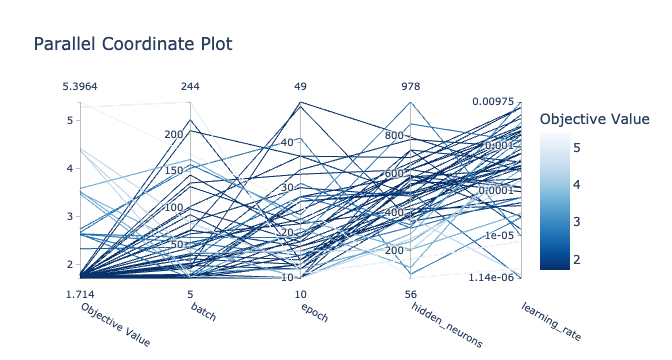

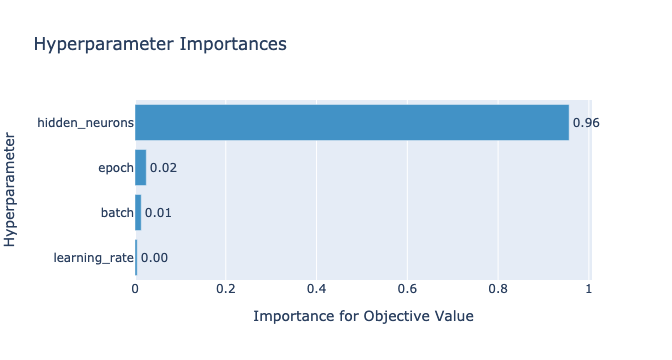

In [34]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.show()
fig.write_image("results/parallel.jpg", scale=3)

fig = optuna.visualization.plot_param_importances(study)
fig.show()
fig.write_image("results/importance.jpg", scale=3)